In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.stats as scs

In [2]:
!whoami
!date

ndbs
Wed Feb  5 16:26:12 PST 2020


## Try Beta distributions

Function from James for converting mean and variance into parameters for Beta

In [6]:
def a_b_from_mean_var(mean, variance):
    if mean <= 0 or mean >= 1:
        raise ValueError("Mean must be in the interval (0,1)")
    if variance >= mean*(1-mean):
        raise ValueError("Variance too large")
        
    a = mean*(mean*(1-mean)/variance - 1)
    b = (1-mean)*(mean*(1-mean)/variance - 1)
    return a, b

In [4]:
.2*(1-.2)

0.16000000000000003

In [38]:
mean, variance = .2, 0.02
a, b = a_b_from_mean_var(mean, variance)

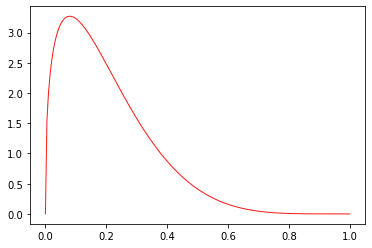

In [39]:
fig, ax = plt.subplots(1,1)

x = np.linspace(0, 1, 200)
# x = np.linspace(loc_left, loc_left+scale, 200)
# x = np.linspace(scs.beta.ppf(0.01, a, b), scs.beta.ppf(0.99, a, b), 100)
ax.plot(x, scs.beta.pdf(x, a, b), 'r-', lw=1, alpha=0.9, label='beta pdf')

plt.show()

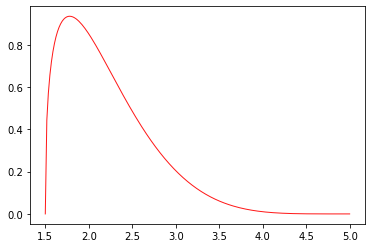

In [40]:
loc_left, scale = 1.5, 5-1.5

fig, ax = plt.subplots(1,1)

x = np.linspace(loc_left, loc_left+scale, 200)
# x = np.linspace(loc_left, loc_left+scale, 200)
# x = np.linspace(scs.beta.ppf(0.01, a, b), scs.beta.ppf(0.99, a, b), 100)
ax.plot(x, scs.beta.pdf(x, a, b, loc_left, scale), 'r-', lw=1, alpha=0.9, label='beta pdf')

plt.show()

In [44]:
print((mean*scale+loc_left), variance*scale**2)

2.2 0.245


In [45]:
print((2.2-loc_left)/scale, 0.245/scale**2)

0.20000000000000004 0.02


In [46]:
def get_standardized_mean_var(mean, variance, loc, scale):
    return (mean-loc)/scale, variance/scale**2

def get_transformed_mean_var(mean, variance, loc, scale):
    return (mean*scale+loc), variance*scale**2

In [66]:
loc, scale = 1.5, 5-1.5
mean, variance = 2, 0.1*scale**2
get_standardized_mean_var(mean, variance, loc, scale)

(0.14285714285714285, 0.1)

In [67]:
0.14285714285714285*(1-0.14285714285714285)

0.12244897959183673

In [68]:
std_mean, std_variance = get_standardized_mean_var(mean, variance, loc, scale)
a, b = a_b_from_mean_var(std_mean, std_variance)
print(a,b)

0.03206997084548102 0.19241982507288616


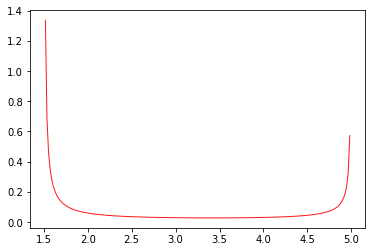

In [69]:
fig, ax = plt.subplots(1,1)

x = np.linspace(loc, loc+scale, 200)
ax.plot(x, scs.beta.pdf(x, a, b, loc, scale), 'r-', lw=1, alpha=0.9, label='beta pdf')

plt.show()

In [70]:
5-1.5

3.5

## Try a Gamma distribution

In [92]:
import scipy.stats

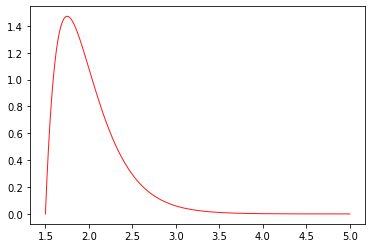

In [190]:
mean = 2 # desired mean of shifted Gamma distribution
loc = 1.5 # location paramter is the left endpoint of the shifted distribution's support
width = 5 - loc # upper bound - lower bound = 3.5
std_mean = mean - loc # "standardized" mean, of the un-shifted distribution
a = 2 # shape parameter
scale = std_mean/a # mean of standard Gamma is std_mean=shape*scale, so scale = std_mean/shape

fig, ax = plt.subplots(1,1)

x = np.linspace(loc, loc+width, 200)
ax.plot(x, scipy.stats.gamma.pdf(x, a, loc, scale), 'r-', lw=1, alpha=0.9, label='gamma pdf')

plt.show()

In [191]:
print(scipy.stats.gamma.cdf(5, a, loc, scale),
     scipy.stats.gamma.sf(5, a, loc, scale),
     scipy.stats.gamma.stats(a, loc=loc, scale=scale, moments='mvsk'))

0.9999875270692135 1.2472930786553525e-05 (array(2.), array(0.125), array(1.41421356), array(3.))


In [192]:
scipy.stats.gamma.sf(3, a, loc, scale)

0.01735126523666451

## Try a lognormal distribution